# Ablation Analysis for the Conv2d Module
## Imports & Definitions

In [24]:
import sys
sys.path.append('../')
import itertools
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from utils.data_utils import preprocess_and_normalize_energy_data, parse_codecarbon_output
from sklearn.linear_model import LinearRegression
from utils.experiments_utils import split_data_set, fit_model, compute_log_transformed_features, apply_data_transforms, test_model
%load_ext autoreload
%autoreload 2
SEED = 1223

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [25]:
d1 = parse_codecarbon_output(
    '../data/conv2d/00_conv2d-raw.csv',
    False,
    ('../data/conv2d/00_conv2d-slurm-log.out','conv2d',False,3)
)
print("dataset shape:", d1.shape)

Dropped observations with the following indices: [24, 69, 102, 175, 183, 303, 382, 406, 467, 552, 619, 751, 761, 853, 901, 902, 955, 1009, 1041, 1060, 1089, 1106, 1225, 1230, 1330, 1365, 1423, 1449]
dataset shape: (1472, 39)


In [26]:
d2 = parse_codecarbon_output(
    '../data/conv2d/02_conv2d-raw.csv',
    False,
    ('../data/conv2d/02_conv2d-slurm-log.out','conv2d',True,3)
)
print("dataset shape:", d2.shape)

Dropped observations with the following indices: [6, 7, 8, 21, 22, 23, 60, 61, 62, 165, 166, 167, 174, 175, 176, 228, 229, 230, 246, 247, 248, 303, 304, 305, 456, 457, 458, 498, 499, 500, 546, 547, 548, 666, 667, 668, 675, 676, 677, 783, 784, 785, 798, 799, 800, 864, 865, 866, 897, 898, 899, 945, 946, 947, 1107, 1108, 1109, 1113, 1114, 1115, 1242, 1243, 1244, 1362, 1363, 1364, 1371, 1372, 1373, 1452, 1453, 1454]
dataset shape: (1428, 39)


In [27]:
param_cols = ['batch_size','image_size','kernel_size','in_channels','out_channels','stride','padding']
data_unnormalized = pd.concat([d1,d2])
data = preprocess_and_normalize_energy_data(data_unnormalized, param_cols, aggregate=True)

Final shape of data set: (976, 28)


## Ablation Analysis
### Compute all possible feature-sets

In [36]:
data_with_log, param_cols_with_log = compute_log_transformed_features(data, param_cols)
feature_names = param_cols_with_log + ['macs']
all_feature_comb_all_sizes = []
for i in range(1, len(feature_names) + 1):
    all_feature_comb_all_sizes.extend(itertools.combinations(feature_names, i))
print(feature_names)

['batch_size', 'image_size', 'kernel_size', 'in_channels', 'out_channels', 'stride', 'padding', 'log_batch_size', 'log_image_size', 'log_kernel_size', 'log_in_channels', 'log_out_channels', 'log_stride', 'log_padding', 'macs']


### Fit the model to all feature-sets

In [29]:
transformers_dict = {
    "x_preprocessors": [StandardScaler()],
    "y_preprocessor": MinMaxScaler()
}
scores = pd.DataFrame(columns=['feature_set','val_score','test_score'])
for f_set in tqdm(all_feature_comb_all_sizes):
    dfs = split_data_set(data_with_log.copy(), list(f_set), SEED, False)
    dfs, _ = apply_data_transforms(dfs, transformers_dict)
    model, val_score, val_mse = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False, verbose=False)
    y_hat, test_score, test_mse = test_model(model,dfs["x_test"],dfs["y_test"], plot_results=False, verbose=False)
    new_row = {
        'feature_set': str(f_set),
        'val_score':val_score,
        'test_score':test_score
    }
    scores = pd.concat([scores, pd.DataFrame(new_row, index=[0])], ignore_index = True, axis = 0)

100%|██████████| 32767/32767 [14:50<00:00, 36.81it/s]


## Evaluate Scores

In [30]:
custom_label_macs = []
for idx, row in scores.iterrows():
    if 'macs' in row.feature_set:
        custom_label_macs.append(True)
    else:
        custom_label_macs.append(False)
scores['with_MACs'] = custom_label_macs
scores.head()

,feature_set,val_score,test_score,with_MACs
0,"('batch_size',)",0.035712,0.019013,False
1,"('image_size',)",0.072369,0.041504,False
2,"('kernel_size',)",0.029958,0.072077,False
3,"('in_channels',)",0.045093,0.023663,False
4,"('out_channels',)",0.016527,-0.002558,False


max score with MACs:  0.9980713676560352 ('batch_size', 'image_size', 'kernel_size', 'in_channels', 'stride', 'log_image_size', 'log_kernel_size', 'log_out_channels', 'log_stride', 'log_padding', 'macs')
min score with MACs:  0.9971916564961691 ('out_channels', 'log_out_channels', 'macs')
max score without MACs:  0.25068152356422424 ('batch_size', 'image_size', 'kernel_size', 'in_channels', 'stride', 'log_batch_size', 'log_image_size', 'log_kernel_size', 'log_out_channels', 'log_stride')
min score without MACs:  -0.02672968998584735 ('padding', 'log_padding')


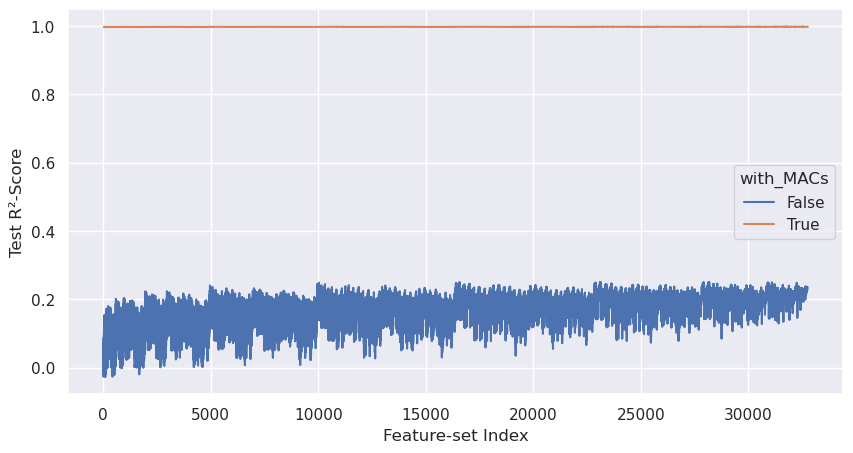

In [34]:
plt.figure(figsize=(10,5))
g = sns.lineplot(y=scores.test_score, x=scores.index, hue=scores.with_MACs)
# g.legend(['with MACs', 'without MACs'], title="feature-set")
g.set_xlabel('Feature-set Index')
g.set_ylabel('Test R²-Score')
scores['test_score'] = pd.to_numeric(scores['test_score'])
print("max score with MACs: ", max(scores.loc[scores.with_MACs == True].test_score), scores.iloc[scores.loc[scores.with_MACs == True].test_score.idxmax()].feature_set)
print("min score with MACs: ", min(scores.loc[scores.with_MACs == True].test_score), scores.iloc[scores.loc[scores.with_MACs == True].test_score.idxmin()].feature_set)
print("max score without MACs: ", max(scores.loc[scores.with_MACs == False].test_score), scores.iloc[scores.loc[scores.with_MACs == False].test_score.idxmax()].feature_set)
print("min score without MACs: ", min(scores.loc[scores.with_MACs == False].test_score), scores.iloc[scores.loc[scores.with_MACs == False].test_score.idxmin()].feature_set)